In [5]:
import sklearn.svm as sk
import sklearn.metrics as metrics
import sklearn.decomposition as decomp
import sklearn.preprocessing as preproc
import sklearn.pipeline as skp
import sklearn.model_selection as skmodel
import pandas as pd
import minisom
import matplotlib.pyplot as plt
import numpy as np

In [143]:
df_main = pd.read_csv(r'features_canon.csv')

In [145]:
df_main.set_index("index", inplace = True)

In [146]:
df_main = df_main.replace(np.nan, 0)

In [148]:
2960-296

2664

In [149]:
df_train = df_main.head(2664)
df_test = df_main.tail(296)

In [248]:
# Following function from Aneesha Bakharia
# https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

def plot_coefficients(coefs, feature_names, current_class, top_features=20):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coefs[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coefs[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title("Coefficients for "+current_class)
    plt.savefig('coef/coefs_' + current_class + '.png')
    # TODO: write them to disk as CSV files

In [282]:
def train_svm(train, test, cross_validate=None, k=10, dim_reduc=None, norms=True, kernel="LinearSVC", final_pred=False,
              get_coefs=False):
    """
    Function to train svm
    :param train: train data... (in panda dataframe)
    :param test: test data (itou)
    :param cross_validate: whether or not to perform cross validation (possible values: leave-one-out and k-fold)
    :param k: k parameter for k-fold cross validation
    :param dim_reduc: dimensionality reduction of input data. Implemented values are pca and som.
    :param norms: perform normalisations, i.e. z-scores and L2 (default True)
    :param kernel: kernel for SVM
    :param final_pred: do the final predictions?
    :param get_coefs, if true, writes to disk (coefficients.csv) and plots the most important coefficients for each class
    :return: returns a pipeline with a fitted svm model, and if possible prints evaluation and writes to disk:
    confusion_matrix.csv, misattributions.csv and (if required) FINAL_PREDICTIONS.csv
    """

    print(".......... Formatting data ........")
    # Save the classes
    classes = list(train.canon)
    train = train.drop(['canon'], axis=1)

    if test is not None:
        #classes_test = list(test.loc[:, 'author'])
        classes_test = list(test.canon) 
        test = test.drop(['canon'], axis=1)
        preds_index = list(test.index)

    nfeats = train.columns.__len__()

    # CREATING PIPELINE
    print(".......... Creating pipeline according to user choices ........")
    estimators = []

    if norms:
        # Z-scores
        # TODO: me suis embeté à implémenter quelque chose qui existe
        # déjà via sklearn.preprocessing.StandardScaler()
        print(".......... using normalisations ........")
        estimators.append(('scaler', preproc.StandardScaler()))
        # NB: j'utilise le built-in
        # normalisation L2
        # cf. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer

        estimators.append(('normalizer', preproc.Normalizer()))

    print(".......... choosing SVM ........")

    if kernel == "LinearSVC":
        # try a faster one
        estimators.append(('model', sk.LinearSVC()))
        # classif = sk.LinearSVC()

    else:
        estimators.append(('model', sk.SVC(kernel=kernel)))
        # classif = sk.SVC(kernel=kernel)

    print(".......... Creating pipeline with steps ........")
    print(estimators)
    pipe = skp.Pipeline(estimators)

    # And now the simple case where there is only one svm to train

    pipe.fit(train, classes)
    preds = pipe.predict(test)
        # and evaluate
    unique_labels = list(set(classes + classes_test))

    pd.DataFrame(metrics.confusion_matrix(classes_test, preds, labels=unique_labels),
                         index=['true:{:}'.format(x) for x in unique_labels],
                         columns=['pred:{:}'.format(x) for x in unique_labels]).to_csv("confusion_matrix.csv")

    print(metrics.classification_report(classes_test, preds))

    # AND NOW, we need to evaluate or create the final predictions
    if final_pred:
        print(".......... Writing final predictions to FINAL_PREDICTIONS.csv ........")
        # Get the decision function too
        myclasses = pipe.classes_
        decs = pipe.decision_function(test)
        #######ERROR --- resolu
        dists = {}
        dists["canon"] = decs

        pd.DataFrame(data={**{'filename': preds_index, 'non-canon': list(preds)}, **dists}).to_csv("FINAL_PREDICTIONS.csv")


    if get_coefs:
        print("..........   Get Coef    ..........")
        # For “one-vs-rest” LinearSVC the attributes coef_ and intercept_ have the shape (n_classes, n_features) and
        # (n_classes,) respectively.
        # Each row of the coefficients corresponds to one of the n_classes “one-vs-rest” classifiers and similar for the
        # intercepts, in the order of the “one” class.
        # Save coefficients for the last model
        
        #####ERROR    --- pipe.named_steps['model'].coef_  --- resolu
        pd.DataFrame(pipe.named_steps['model'].coef_,
                         index=['non-canon'],
                         columns=train.columns).to_csv("coefficients.csv")

        # TODO: optionalise  the number of top_features… ?
        plot_coefficients(pipe.named_steps['model'].coef_[0], train.columns, str(pipe.classes_[0]))

    return pipe

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('normalizer', Normalizer(copy=True, norm='l2')), ('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]
              precision    recall  f1-score   support

       canon       0.55      0.17      0.26        36
   non_canon       0.89      0.98      0.94       260

    accuracy                           0.88       296
   macro avg       0.72      0.57      0.60       296
weighted avg       0.85      0.88      0.85       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get

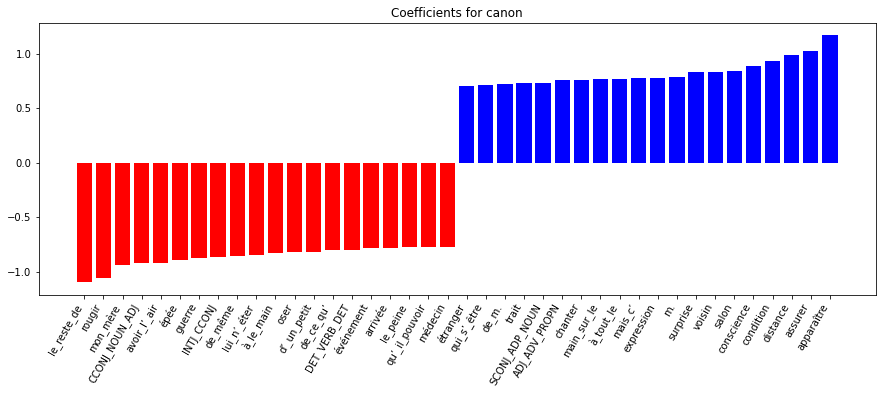

In [274]:
svm_1 = train_svm(df_train, df_test, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [137]:
df_main_temp = pd.read_csv(r'features_fabula.csv')

In [138]:
df_main_temp.set_index("index", inplace = True)

In [139]:
df_main_temp = df_main_temp.replace(np.nan, 0)

In [140]:
df_train_temp = df_main_temp.head(2664)
df_test_temp = df_main_temp.tail(296)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('normalizer', Normalizer(copy=True, norm='l2')), ('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]
              precision    recall  f1-score   support

       False       0.91      0.92      0.92       174
        True       0.88      0.88      0.88       122

    accuracy                           0.90       296
   macro avg       0.90      0.90      0.90       296
weighted avg       0.90      0.90      0.90       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get

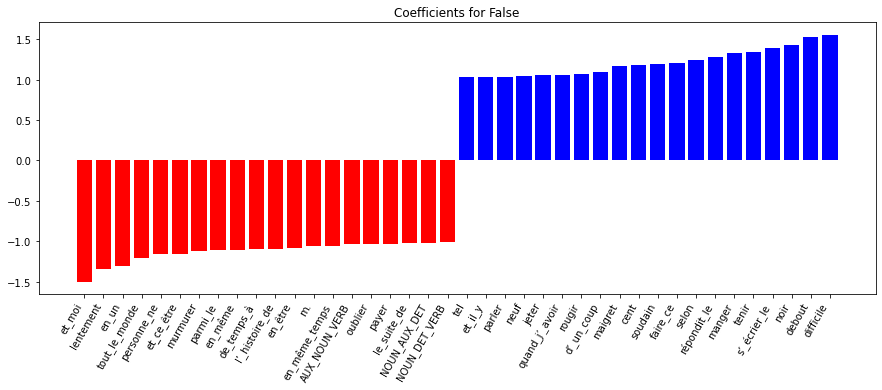

In [275]:
svm_2 = train_svm(df_train_temp, df_test_temp, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [131]:
import random

In [132]:
random_list = [bool(random.getrandbits(1)) for i in range(2960)]

In [134]:
df_main_temp["canon"] = random_list

In [135]:
df_train_rand = df_main_temp.head(2664)
df_test_rand = df_main_temp.tail(296)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('normalizer', Normalizer(copy=True, norm='l2')), ('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]
              precision    recall  f1-score   support

       False       0.59      0.48      0.53       164
        True       0.47      0.58      0.52       132

    accuracy                           0.52       296
   macro avg       0.53      0.53      0.52       296
weighted avg       0.53      0.52      0.52       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get

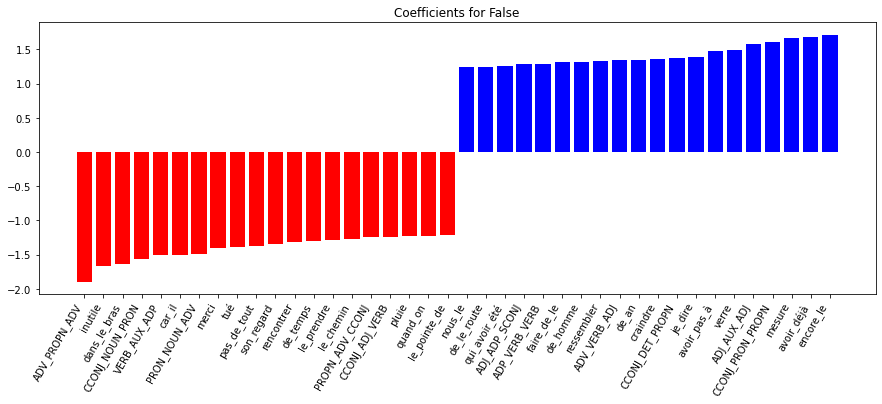

In [276]:
svm_3 = train_svm(df_train_rand, df_test_rand, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [20]:
df_main_balanced = pd.read_csv(r'features_balanced.csv')

In [22]:
df_main_balanced.set_index("index", inplace = True)

In [23]:
df_main_balanced = df_main_balanced.replace(np.nan, 0)

In [25]:
df_train_balanced = df_main_balanced.head(470)
df_test_balanced = df_main_balanced.tail(52)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('normalizer', Normalizer(copy=True, norm='l2')), ('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]
              precision    recall  f1-score   support

       canon       0.81      0.83      0.82        30
   non_canon       0.76      0.73      0.74        22

    accuracy                           0.79        52
   macro avg       0.78      0.78      0.78        52
weighted avg       0.79      0.79      0.79        52

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get

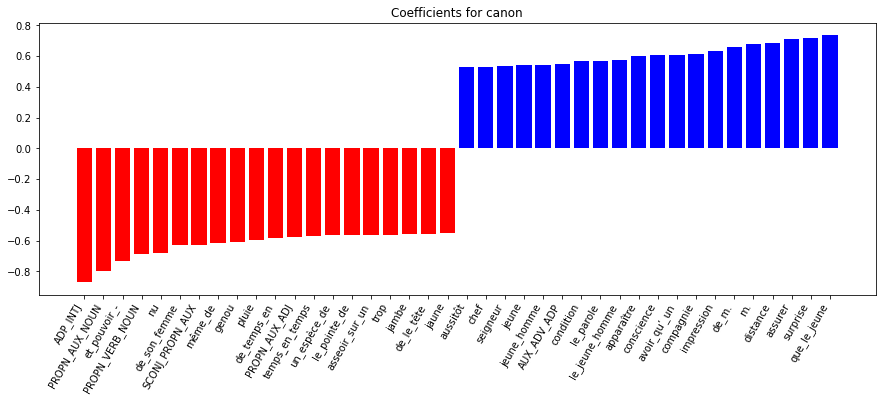

In [277]:
svm_4 = train_svm(df_train_balanced, df_test_balanced, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [60]:
df_main_balanced_unigram = pd.read_csv(r'features_balanced_unigram.csv')

In [61]:
df_main_balanced_unigram.set_index("index", inplace = True)

In [62]:
df_main_balanced_unigram = df_main_balanced_unigram.replace(np.nan, 0)

In [63]:
df_train_balanced_unigram = df_main_balanced_unigram.head(470)
df_test_balanced_unigram = df_main_balanced_unigram.tail(52)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('normalizer', Normalizer(copy=True, norm='l2')), ('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]
              precision    recall  f1-score   support

       canon       0.79      0.73      0.76        30
   non_canon       0.67      0.73      0.70        22

    accuracy                           0.73        52
   macro avg       0.73      0.73      0.73        52
weighted avg       0.74      0.73      0.73        52

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get

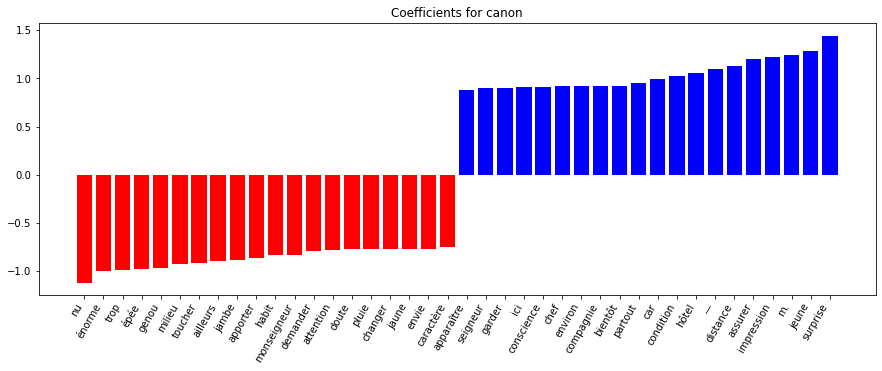

In [278]:
svm_5 = train_svm(df_train_balanced_unigram, df_test_balanced_unigram, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [58]:
df_main_balanced_tout_sauf_unigram = pd.read_csv(r'features_balanced_tout_sauf_unigram.csv')

In [46]:
df_main_balanced_tout_sauf_unigram.set_index("index", inplace = True)

In [47]:
df_main_balanced_tout_sauf_unigram = df_main_balanced_tout_sauf_unigram.replace(np.nan, 0)

In [48]:
df_train_balanced_tout_sauf_unigram = df_main_balanced_tout_sauf_unigram.head(470)
df_test_balanced_tout_sauf_unigram = df_main_balanced_tout_sauf_unigram.tail(52)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('normalizer', Normalizer(copy=True, norm='l2')), ('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]
              precision    recall  f1-score   support

       canon       0.79      0.77      0.78        30
   non_canon       0.70      0.73      0.71        22

    accuracy                           0.75        52
   macro avg       0.74      0.75      0.75        52
weighted avg       0.75      0.75      0.75        52

..........   Get Coef    ..........


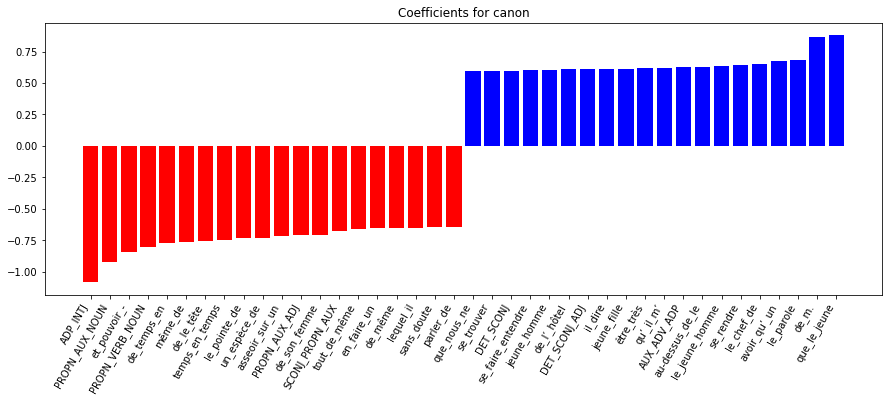

In [260]:
svm_6 = train_svm(df_train_balanced_tout_sauf_unigram, df_test_balanced_tout_sauf_unigram, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)